In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn
seaborn.set()
seaborn.set_style('dark')
np.set_printoptions(precision=3)

%matplotlib inline

In [2]:
import sklearn
import sklearn.metrics
import sklearn.grid_search
import sklearn.linear_model
import sklearn.cross_validation
import sklearn.preprocessing
import sklearn.pipeline
import pescador

In [3]:
import glob

In [4]:
def load_file(filename, n_pos=32, n_neg=32):
    
    data = np.load(filename)
    
    d = data['X'].shape[1]
    
    if n_pos is None:
        return data['X'], data['Y']
    
    
    positives = np.flatnonzero(data['Y'])
    negatives = np.flatnonzero(1-data['Y'])
    n_pos = min(n_pos, len(positives))
    n_neg = min(n_neg, len(negatives))
    
    X = np.empty((n_pos + n_neg, d), dtype=np.float32)
    Y = np.zeros((n_pos + n_neg), dtype=np.int32)
    
    if n_pos > 0:
        idx_pos = np.random.choice(positives, size=n_pos, replace=True)
    
        X[:n_pos] = np.take(data['X'], idx_pos, axis=0)
        Y[:n_pos] = 1
    
    if n_neg > 0:
        idx_neg = np.random.choice(negatives, size=n_neg, replace=True)
        X[n_pos:] = np.take(data['X'], idx_neg, axis=0)
    
    return X, Y

In [5]:
def load_batch(files, n_pos=32, n_neg=32):
    
    X = []
    Y = []
    
    for fn in files:
        _x, _y = load_file(fn, n_pos=n_pos, n_neg=n_neg)
        if _x.shape[0] == 0:
            continue
        X.append(_x)
        Y.append(_y)
        
    X = np.concatenate(X, axis=0)
    Y = np.concatenate(Y, axis=0)
    
    return X, Y

In [6]:
NEG_TO_POS = 156 # salami
#NEG_TO_POS = 157 # Isophonics
N_POS = 10

In [7]:
files = sorted(glob.glob('../data/labeled_features/SALAMI_*_beats.npz'))
#files = sorted(glob.glob('../data/labeled_features/Isophonics_*_beats.npz'))

In [14]:
filesplitter = sklearn.cross_validation.ShuffleSplit(len(files), n_iter=1, test_size=0.80, random_state=5)
_files = np.asarray(files)

In [15]:
import sklearn.ensemble

In [ ]:
for trainf, testf in filesplitter:
    
    print 'Loading training data...'
    X_train, Y_train = load_batch([_files[_] for _ in trainf],
                                 n_pos=N_POS,
                                 n_neg=NEG_TO_POS * N_POS)
    
    _model = sklearn.grid_search.GridSearchCV(sklearn.linear_model.SGDClassifier(loss='log', verbose=1),
                                             {'alpha': np.logspace(-3, 1, num=4, endpoint=False),
                                             'penalty': ['l1', 'l2', 'elasticnet']},
                                             n_jobs=1, verbose=1)
    
    #_model = sklearn.grid_search.GridSearchCV(sklearn.ensemble.RandomForestClassifier(),
    #                                         {'max_depth': np.arange(2, 11)},
    #                                         n_jobs=3, verbose=1)
    
    feature = sklearn.preprocessing.StandardScaler()
    model = sklearn.pipeline.Pipeline([('scaler', feature), ('predictor', _model)])
    
    model.fit(X_train, Y_train)
    
    print 'Loading testing data...'
    X_test, Y_test = load_batch([_files[_] for _ in testf],
                                n_pos=None,
                                n_neg=None)

Loading training data...
Fitting 3 folds for each of 12 candidates, totalling 36 fits
-- Epoch 1
Norm: 499.29, NNZs: 639, Bias: -604.606038, T: 101354, Avg. loss: 5.379499
Total training time: 0.92 seconds.
-- Epoch 2
Norm: 496.39, NNZs: 598, Bias: -603.536065, T: 202708, Avg. loss: 4.220530
Total training time: 1.82 seconds.
-- Epoch 3
Norm: 494.98, NNZs: 576, Bias: -602.746986, T: 304062, Avg. loss: 3.789710
Total training time: 2.73 seconds.
-- Epoch 4
Norm: 494.17, NNZs: 559, Bias: -602.053147, T: 405416, Avg. loss: 3.556189
Total training time: 3.64 seconds.
-- Epoch 5
Norm: 493.59, NNZs: 551, Bias: -601.483058, T: 506770, Avg. loss: 3.406149
Total training time: 4.55 seconds.
-- Epoch 1
Norm: 550.30, NNZs: 660, Bias: -658.775751, T: 101356, Avg. loss: 6.067528
Total training time: 0.86 seconds.
-- Epoch 2
Norm: 546.70, NNZs: 635, Bias: -658.066880, T: 202712, Avg. loss: 4.792722
Total training time: 1.73 seconds.
-- Epoch 3
Norm: 544.93, NNZs: 619, Bias: -657.459709, T: 304068, A

[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:    6.0s
[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed:  2.5min finished



Total training time: 4.00 seconds.
-- Epoch 1
Norm: 183.52, NNZs: 77, Bias: -94.220505, T: 152033, Avg. loss: 0.602323
Total training time: 1.43 seconds.
-- Epoch 2
Norm: 183.65, NNZs: 55, Bias: -93.634905, T: 304066, Avg. loss: 0.526609
Total training time: 2.77 seconds.
-- Epoch 3
Norm: 183.72, NNZs: 46, Bias: -93.296836, T: 456099, Avg. loss: 0.508367
Total training time: 4.13 seconds.
-- Epoch 4
Norm: 183.77, NNZs: 43, Bias: -93.056306, T: 608132, Avg. loss: 0.503644
Total training time: 5.64 seconds.
-- Epoch 5
Norm: 183.80, NNZs: 39, Bias: -92.869068, T: 760165, Avg. loss: 0.503335
Total training time: 7.15 seconds.
Loading testing data...

In [ ]:
M = model.steps[1][1]

In [ ]:
M.best_params_

In [ ]:
w = model.steps[1][1].best_estimator_.coef_[0]
w = w.reshape((-1, 84))
plt.imshow(w.T, aspect='auto', interpolation='none', cmap='coolwarm', origin='lower')
plt.ylabel('CQT bin')
plt.xlabel('Context position')
plt.title('$w$')
plt.xticks(np.arange(5), np.arange(-2, 3))
plt.colorbar()

In [ ]:
print sklearn.metrics.classification_report(Y_train, model.predict(X_train))

In [ ]:
sklearn.metrics.accuracy_score(Y_train, model.predict(X_train))

In [ ]:
Y_pred = [model.predict(xt) for xt in X_test]

In [ ]:
Y_pred_proba = np.concatenate([model.predict_proba(xt) for xt in X_test], axis=0)

In [ ]:
Y_pred = np.concatenate(Y_pred, axis=0)

In [ ]:
print sklearn.metrics.classification_report(Y_test, Y_pred)

In [ ]:
sklearn.metrics.accuracy_score(Y_test, Y_pred)

---

In [22]:
import cPickle as pickle

In [23]:
pickle.dump({'model': model, 'dataset': 'salami_beat'},
            open('../data/similarity_model_salami_beat_bias.pickle', 'w'))
#pickle.dump({'model': model, 'dataset': 'isophonics_beat'},
            #open('../data/similarity_model_isophonics_beat_bias_est.pickle', 'w'))

---

In [98]:
Xtrains2 = np.mean(X_train**2, axis=1, keepdims=True)

In [99]:
Xtests2 = np.mean(X_test**2, axis=1, keepdims=True)

In [100]:
seaborn.set_style('darkgrid')

In [101]:
import sklearn.neighbors

In [102]:
KDE_pos = sklearn.grid_search.GridSearchCV(sklearn.neighbors.KernelDensity(),
                                           {'bandwidth': np.linspace(0.1, 1.0, 5)},
                                           verbose=1,
                                           n_jobs=3,
                                           cv=5)
KDE_pos.fit(Xtrains2[Y_train > 0])

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=3)]: Done   1 jobs       | elapsed:   11.5s
[Parallel(n_jobs=3)]: Done  21 out of  25 | elapsed:  1.5min remaining:   17.3s
[Parallel(n_jobs=3)]: Done  25 out of  25 | elapsed:  1.7min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=KernelDensity(algorithm='auto', atol=0, bandwidth=1.0, breadth_first=True,
       kernel='gaussian', leaf_size=40, metric='euclidean',
       metric_params=None, rtol=0),
       fit_params={}, iid=True, loss_func=None, n_jobs=3,
       param_grid={'bandwidth': array([ 0.1  ,  0.325,  0.55 ,  0.775,  1.   ])},
       pre_dispatch='2*n_jobs', refit=True, score_func=None, scoring=None,
       verbose=1)

In [103]:
KDE_neg = sklearn.grid_search.GridSearchCV(sklearn.neighbors.KernelDensity(),
                                           {'bandwidth': np.linspace(0.1, 1.0, 3)},
                                           verbose=1,
                                           n_jobs=3,
                                           cv=5)
KDE_neg.fit(Xtrains2[Y_train < 1])

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=3)]: Done   1 jobs       | elapsed:   14.5s
[Parallel(n_jobs=3)]: Done  11 out of  15 | elapsed:  1.2min remaining:   25.4s
[Parallel(n_jobs=3)]: Done  15 out of  15 | elapsed:  1.4min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=KernelDensity(algorithm='auto', atol=0, bandwidth=1.0, breadth_first=True,
       kernel='gaussian', leaf_size=40, metric='euclidean',
       metric_params=None, rtol=0),
       fit_params={}, iid=True, loss_func=None, n_jobs=3,
       param_grid={'bandwidth': array([ 0.1 ,  0.55,  1.  ])},
       pre_dispatch='2*n_jobs', refit=True, score_func=None, scoring=None,
       verbose=1)

In [104]:
Y_pred_kde = (KDE_pos.best_estimator_.score_samples(Xtests2) >
              KDE_neg.best_estimator_.score_samples(Xtests2))

In [105]:
print sklearn.metrics.classification_report(Y_test[:len(Y_pred_kde)], Y_pred_kde)

             precision    recall  f1-score   support

          0       0.66      0.68      0.67    143276
          1       0.58      0.56      0.57    114243

avg / total       0.62      0.62      0.62    257519



ValueError: need more than 1 value to unpack

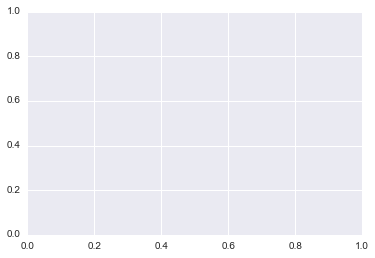

In [106]:
seaborn.kdeplot(np.log(Xtrains2[Y_train > 0]), shade=True, label='Positive')
seaborn.kdeplot(np.log(Xtrains2[Y_train < 1]), shade=True, label='Negative')
plt.legend(loc='best')